<a href="https://colab.research.google.com/github/ksairos/tf-advanced-techniques-course/blob/main/course_4/C4_W2_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 Convolutional AutoEncoder

## Imports

In [15]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

K = tf.keras.backend

## Load and Preprocess data

In [ ]:
# Preprocessing Function

def map_image(image, label):
  image = tf.cast(image, tf.float32)
  image = image / 255.0
  return image, image

# Parameters
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

# Load and prepare training data
train_dataset = tfds.load('cifar10', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# Load and prepare test data
test_dataset = tfds.load('cifar10', as_supervised=True, split="test")
test_dataset = test_dataset.map(map_image)
test_dataset = test_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

## Build the model

### Define functions for Encoder, Decoder, and Bottleneck

In [16]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from keras import Model

# Encoder
def encoder(inputs):
  ''' 
  input shape : (32, 32, 3)
  output shape : (4, 4, 128)
  '''
  conv_1 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  max_pool_1 = MaxPooling2D(pool_size=(2,2))(conv_1)

  conv_2 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(max_pool_1)
  max_pool_2 = MaxPooling2D(pool_size=(2,2))(conv_2)

  conv_3 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(max_pool_2)
  max_pool_3 = MaxPooling2D(pool_size=(2,2))(conv_3)

  return max_pool_3


# Bottleneck
def bottleneck(inputs):
  ''' 
  input shape : (4, 4, 128)
  auto-encoder output shape : (4, 4, 256)
  encoder output for viz: (4, 4, 1)
  '''
  auto_encoder_output = Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  encoder_viz_output = Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(inputs)

  return auto_encoder_output, encoder_viz_output


# Decoder
def decoder(inputs):
  ''' 
  input shape : (4, 4, 256)
  output shape : (32, 32, 3)
  '''
  conv_1 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  upsample_1 = UpSampling2D(size=(2,2))(conv_1)

  conv_2 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(upsample_1)
  upsample_2 = UpSampling2D(size=(2,2))(conv_2)

  conv_3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(upsample_2)
  upsample_3 = UpSampling2D(size=(2,2))(conv_3)

  conv_4 = Conv2D(filters=3, kernel_size=(3,3), activation='sigmoid', padding='same')(upsample_3)

  return conv_4


# Define the complete model
def create_autoencoder():
  input = Input(shape=(32, 32, 3))

  encoder_output = encoder(input)
  bottleneck_output, viz_output = bottleneck(encoder_output)
  decoder_output = decoder(bottleneck_output)

  model = Model(inputs=input, outputs=decoder_output)
  encoder_model = Model(inputs=input, outputs=viz_output)

  return model, encoder_model

In [17]:
K.clear_session()

model, encoder_model = create_autoencoder()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856 

## Compile the model

In [21]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

## Model Training

In [19]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Callbacks
model_checkpoint_cb = ModelCheckpoint("mymodel.h5", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)

In [ ]:
# training parameters
train_steps = 50000 // BATCH_SIZE
valid_steps = 10000 // BATCH_SIZE

model.fit(train_dataset, steps_per_epoch=train_steps,
          validation_data=test_dataset, validation_steps=valid_steps,
          epochs=40, callbacks=[model_checkpoint_cb, early_stopping_cb])

In [23]:
result = model.evaluate(test_dataset, steps=10)

10/10 [==============================] - 0s 14ms/step - loss: 0.0031 - accuracy: 0.7815


## Display results

In [26]:
mymodel = keras.models.load_model('mymodel.h5')

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Utility functions

def display_one_row(disp_images, offset, shape=(32, 32)):
  '''Display sample outputs in one row.'''
  for idx, test_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    test_image = np.reshape(test_image, shape)
    plt.imshow(test_image, cmap='gray')


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(4,4)):
  '''Displays the input, encoded, and decoded output values.'''
  plt.figure(figsize=(15,5))
  display_one_row(disp_input_images, 0, shape=(32,32,3))
  display_one_row(disp_encoded, 10, shape=enc_shape)  
  display_one_row(disp_predicted, 20, shape=(32,32,3))

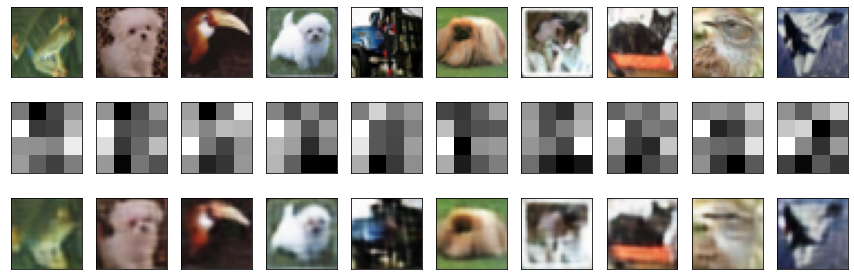

In [32]:
# take 1 batch of the dataset
test_dataset = test_dataset.take(1)

# take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

# pick 10 indices
idxs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# prepare test samples as a batch of 10 images
conv_output_samples = np.array(output_samples[idxs])
conv_output_samples = np.reshape(conv_output_samples, (10, 32, 32, 3))

# get the encoder ouput
encoded = encoder_model.predict(conv_output_samples)

# get a prediction for some values in the dataset
predicted = mymodel.predict(conv_output_samples)

# display the samples, encodings and decoded values!
display_results(conv_output_samples, encoded, predicted, enc_shape=(4,4))